<h1> Generate simulator data </h1>

In [1]:
from pyfme.aircrafts import SimplifiedCessna172, BasisLinear, Debug, Linear
from pyfme.aircrafts.aircraft import Aircraft
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import quaternion

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# aircraft = SimplifiedCessna172()
# aircraft = BasisLinear('../src/pyfme/aircrafts/tmp.json')
aircraft = Linear(alpha_dot=False)
# aircraft = Debug()

In [4]:
from pyfme.environment import Environment
from pyfme.models import RigidBodyEuler, RigidBodyEulerState, RigidBodyQuat, RigidBodyQuatState
from pyfme.aircrafts.aircraft import ConventionalControls
from pyfme.utils.input_generator import Constant, Step, Chirp, Doublet
import time

In [5]:
from pyfme.models.state import copyStateValues

In [6]:
from pyfme.environment.gravity import VerticalConstant

In [7]:
environment = Environment()

In [8]:
controls_seq = {
    'delta_elevator':  Chirp(3., 100., 0., 5.),
    'delta_aileron': Chirp(3., 100., 3., 5.),
    'delta_rudder': Chirp(3., 100., 3., 5.),
    'delta_throttle': Constant(0)
}

In [9]:
state = RigidBodyQuatState(np.array([0,0,0,1.,0,0,0,10.,0,0.0,0,0,0]))

In [10]:
state.attitude = np.array([0,  2.8*np.pi/180 - np.arctan(1/10), 0.])
state.earth_velocity = np.array([5.7, 0., 0.57])
# state.q = 0.0

In [11]:
state.v = 0.2

In [12]:
system = RigidBodyQuat(aircraft, environment)

In [13]:
aircraft.state_dot = None
sol = system.integrate(60., state, controls_seq, dt_eval=0.01, method='RK45')


In [15]:
controls = system.aircraft.get_controls(sol.time, controls_seq)
conditions = system.environment.calculate_aero_conditions(sol)
L, D, Y, l, m, n = system.aircraft._calculate_aero_forces_moments(conditions, sol, controls)

In [16]:
forces, moments = system.aircraft.calculate_forces_and_moments(sol,
                                    conditions, controls)

fg = conditions.gravity_vector * aircraft.mass

In [17]:
CY, Cl, CN = aircraft._calculate_aero_lat_forces_moments_coeffs(sol.alpha, sol.beta, sol.V, sol, controls)

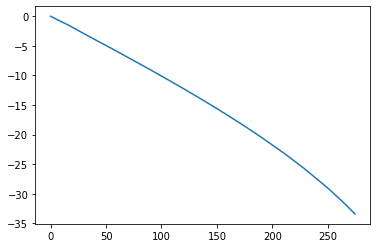

In [18]:
plt.plot(sol.x_e, -sol.z_e)

In [23]:
DF = sol.to_pandas()

In [24]:
DF['alpha'] = sol.alpha
DF['V'] = sol.V

In [25]:
DF['theta'] = sol.theta

In [26]:
DF['L'] = L
DF['D'] = D
DF['m'] = m
DF['l'] = l
DF['n'] = n
DF['Y'] = Y

In [27]:
Qinf = 1/2 * 1.225 * sol.V**2 * aircraft.Sw
DF['CL'] = L/Qinf
DF['CD'] = D/Qinf
DF['Cm'] = m/Qinf/aircraft.chord
DF['Cl'] = l/Qinf/aircraft.span
DF['Cn'] = n/Qinf/aircraft.span
DF['CY'] = Y/Qinf

In [28]:
DF['time'] = sol.time
DF['dx_e'] = sol.earth_velocity[:,0]
DF['dz_e'] = sol.earth_velocity[:,2]

In [29]:
DF['elevator'] = controls.delta_elevator
DF['rudder'] = controls.delta_rudder

In [30]:
DF['aileron'] = controls.delta_aileron

In [31]:
DF.to_csv('tmp.csv')

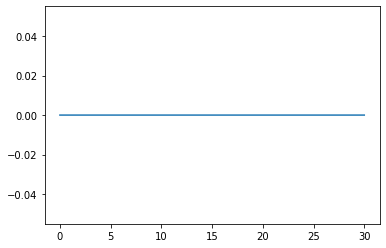

In [22]:
plt.plot(sol.time, controls.delta_aileron)

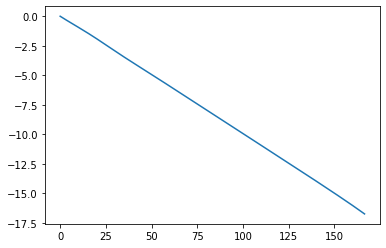

In [23]:
plt.plot(sol.x_e, -sol.z_e)

In [61]:
mml = pd.read_csv('../../../../systemid/MyPackages/mechamod/mechamodlearnprivate/experiments/data.csv') 

# Vary elevator input

In [ ]:
data = []
i=0
for de in np.linspace(-1,1,10):
    for w in np.linspace(-1,1,10):
        # update control sequence
        controls_seq['delta_elevator'] = Step(t_init=1, T=3, A=de, offset=0)
        
        # integrate equations of motion
        sol = system.integrate(5, state, controls_seq)
        d = sol.to_pandas()
        
        # compute controls
        for k in controls_seq:
            d[k] = controls_seq[k](d.time)
        
        # compute forces and moments
        controls = system.aircraft.get_controls(sol.time, controls_seq)
        conditions = system.environment.calculate_aero_conditions(sol)
        L, D, Y, l, m, n = system.aircraft._calculate_aero_forces_moments(conditions, sol, controls)
        d['L'] = L
        d['D'] = D
        d['Y'] = Y 
        d['l'] = l 
        d['m'] = m 
        d['n'] = n 
        
        # save
        d.to_csv('trajectory'+str(i)+'.csv', index=False)
        data.append(d)
        i+=1

# Vary initial condition

In [ ]:
##### ## /!\ Everything is cast to integer

In [12]:
data = []
i=0
for i in range(100):
    # update initial state value
    state.u = np.random.uniform(4,7)
    state.w = np.random.uniform(-.5,2)
    state.q = np.random.uniform(-.05,.05)

    # integrate equations of motion
    sol = system.integrate(5, state, controls_seq)
    d = sol.to_pandas()

    # compute controls
    for k in controls_seq:
        d[k] = controls_seq[k](d.time)

    # compute forces and moments
    controls = system.aircraft.get_controls(sol.time, controls_seq)
    conditions = system.environment.calculate_aero_conditions(sol)
    L, D, Y, l, m, n = system.aircraft._calculate_aero_forces_moments(conditions, sol, controls)
    d['L'] = L
    d['D'] = D
    d['Y'] = Y 
    d['l'] = l 
    d['m'] = m 
    d['n'] = n 

    # save
    d.to_csv('trajectory'+str(i)+'.csv', index=False)
    data.append(d)